## Circuit-Cutting Implementation Details

This notebook expands on the [circuit_cutting](00_circuit_cutting.ipynb) notebook to illustrate some of the workings behind circuit-cutting, along with implementation-specific details in `Cutqc2`.

We create a `CutCircuit` object and use it for circuit-cutting a simple 5-qubit circuit (Figure 4 in the CutQC paper).

In [1]:
from math import pi
from pathlib import Path

import qiskit

from cutqc2.core.cut_circuit import CutCircuit


def example_circuit():
    qc = qiskit.QuantumCircuit(5)
    qc.reset(0)
    qc.reset(1)
    qc.reset(2)
    qc.reset(3)
    qc.reset(4)

    qc.h(0)
    qc.h(1)
    qc.h(2)
    qc.h(3)
    qc.h(4)

    qc.cz(0, 1)
    qc.t(2)
    qc.t(3)
    qc.t(4)

    qc.cz(0, 2)
    qc.rx(pi / 2, 4)

    qc.rx(pi / 2, 0)
    qc.rx(pi / 2, 1)
    qc.cz(2, 4)

    qc.t(0)
    qc.t(1)
    qc.cz(2, 3)
    qc.rx(pi / 2, 4)

    qc.h(0)
    qc.h(1)
    qc.h(2)
    qc.h(3)
    qc.h(4)

    return qc


circuit = example_circuit()

In [2]:
cut_circuit = CutCircuit(circuit=circuit)
cut_circuit.cut(
    max_subcircuit_width=3,  # Max qubits per subcircuit
    max_cuts=1,  # Max total cuts in the circuit
    num_subcircuits=[2],  # Desired number of subcircuits to try
)

(INFO) (cut_circuit.py) (29-Sep-25 19:51:46) Trying with 2 subcircuits
Set parameter Username
(INFO) (mip.py) (29-Sep-25 19:51:46) Set parameter Username
Set parameter LicenseID to value 2646086
(INFO) (mip.py) (29-Sep-25 19:51:46) Set parameter LicenseID to value 2646086
Academic license - for non-commercial use only - expires 2026-04-01
(INFO) (mip.py) (29-Sep-25 19:51:46) Academic license - for non-commercial use only - expires 2026-04-01


### The Computation Graph

The `CutCircuit` class cuts the original circuit into subcircuits. These are internally labeled from `0` to `n-1`. These subcircuits have qubit wires connecting them. In the visual representation of the cut circuit below, we can see that qubit 2 of subcircuit 0 feeds into qubit 0 of subcircuit 1.

In [3]:
print(cut_circuit)

          ┌───┐                   ┌─────────┐┌───┐   ┌───┐        
q_0: ─|0>─┤ H ├──■──────────────■─┤ Rx(π/2) ├┤ T ├───┤ H ├────────
          ├───┤  │  ┌─────────┐ │ └──┬───┬──┘├───┤   └───┘        
q_1: ─|0>─┤ H ├──■──┤ Rx(π/2) ├─┼────┤ T ├───┤ H ├────────────────
          ├───┤┌───┐└─────────┘ │    ├───┴┐  └───┘           ┌───┐
q_2: ─|0>─┤ H ├┤ T ├────────────■────┤ // ├────■───────■─────┤ H ├
          ├───┤├───┤                 └────┘    │       │     ├───┤
q_3: ─|0>─┤ H ├┤ T ├───────────────────────────┼───────■─────┤ H ├
          ├───┤├───┤┌─────────┐                │  ┌─────────┐├───┤
q_4: ─|0>─┤ H ├┤ T ├┤ Rx(π/2) ├────────────────■──┤ Rx(π/2) ├┤ H ├
          └───┘└───┘└─────────┘                   └─────────┘└───┘


This inter-subcircuit qubit wiring results in a *Computation Graph*, available as the `compute_graph` attribute of the `CutCircuit` class. We can draw it out using its `.draw()` method:

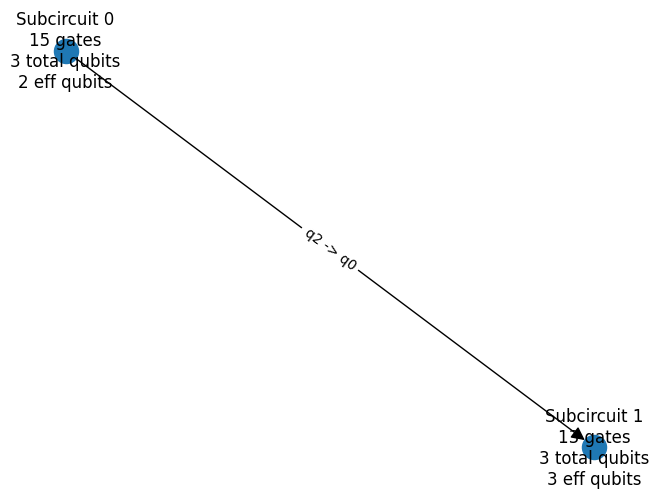

In [4]:
compute_graph = cut_circuit.compute_graph
compute_graph.draw()

This visual representation of the compute graph tells us that:
 - We have 2 subcircuits, 0 and 1.
 - Subcircuit 0 has 15 gates, 3 qubits, 2 of which are "effective" qubits (contributing to the output).
 - Subcircuit 1 has 13 gates, 3 qubits, all 3 of which are "effective" (contributing to the output).
 - Qubit 2 (`q2`) of Subcircuit 0 feeds in as Qubit 0 (`q0`) of Subcircuit 1 (notice the direction of the arrow connecting the blue nodes).

**Each edge of this compute graph represents the qubit wire that is being cut** as part of circuit-cutting.

If we run the subcircuits of this `CutCircuit` object, we end up populating the individual subcircuit probability values as the `subcircuit_packed_probs` attribute.

Circuit cutting decomposes any unknown quantum states at cut points into a linear combination of their Pauli bases, summing over four pairs of measurement circuits appended to the upstream subcircuit (subcircuit 0) and state initialization circuits prepended to the downstream subcircuit (subcircuit 1).

Specifically, QPUs run four variations of subcircuit 0, each measures the upstream cut qubit q2 in one of the {I, X, Y, Z}
Pauli bases. Correspondingly, QPUs run four variations of subcircuit 1, each initializes the downstream cut qubit q0 in one of the {|0⟩, |1⟩, |+⟩, |i⟩}
states. 

Thus, in this example, subcircuit 0 will have $4^{1}$ probability vectors (each of length $2^{2}$ since it has 2 effective qubits), and subcircuit 1 will have $4^{1}$ probability vectors (each of length $2^{3}$ since it has 3 effective qubits).

We can run the subcircuits and confirm that this is the case.

In [5]:
cut_circuit.run_subcircuits()

(INFO) (cut_circuit.py) (29-Sep-25 19:51:46) Running subcircuit 0 on backend: statevector_simulator
(INFO) (cut_circuit.py) (29-Sep-25 19:51:46) Running subcircuit 1 on backend: statevector_simulator


In [6]:
cut_circuit.subcircuit_packed_probs[0].shape

(4, 4)

In [7]:
cut_circuit.subcircuit_packed_probs[1].shape

(4, 8)

### A more complex example

If we create a 6-qubit Supremacy circuit, cut it, run the subcircuits, and plot the computation graph. *We're supplying the location of cuts manually through the **subcircuits** parameter to keep the example reproducible.* You will almost never need to do this in a real setting.

(INFO) (cut_circuit.py) (29-Sep-25 19:51:46) Running subcircuit 0 on backend: statevector_simulator
(INFO) (cut_circuit.py) (29-Sep-25 19:51:46) Running subcircuit 1 on backend: statevector_simulator
(INFO) (cut_circuit.py) (29-Sep-25 19:51:46) Running subcircuit 2 on backend: statevector_simulator


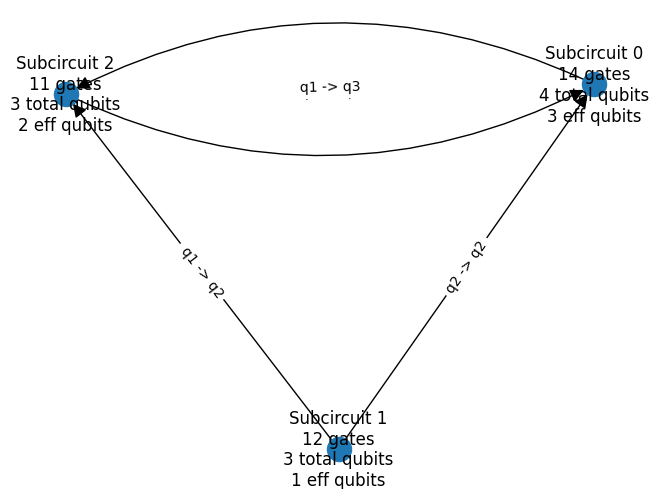

In [8]:
with Path.open("supremacy_6qubit.qasm3", "r") as f:
    circuit_qasm3 = f.read()

cut_circuit = CutCircuit(circuit_qasm3=circuit_qasm3)
cut_circuit.cut(
    subcircuits=[
        ["[0]0 [1]0", "[0]1 [2]1", "[1]1 [3]2"],
        ["[4]0 [5]0", "[2]0 [4]1"],
        ["[2]2 [3]0", "[3]1 [5]1"],
    ]
)
cut_circuit.run_subcircuits()
compute_graph = cut_circuit.compute_graph
compute_graph.draw()

Subcircuit 0 has two incoming edges and one outgoing edge, or in other words, two cut edges upstream and one cut edge downstream. It thus has $4^{2}$ initialization circuits and $4^{1}$ measurement circuits. Each combination of initialization or measurement circuit has a $2^{effective-qubits}$, or $2^{3}$ length probability vector. The total number of probability values for subcircuit 0 thus has the shape `(4, 4, 4, 8)`. Let's confirm this:

In [9]:
cut_circuit.subcircuit_packed_probs[0].shape

(4, 4, 4, 8)

Similarly, for subcircuit 1 and subcircuit 2:

In [10]:
cut_circuit.subcircuit_packed_probs[1].shape

(4, 4, 2)

In [11]:
cut_circuit.subcircuit_packed_probs[2].shape

(4, 4, 4, 4)

If we were to save the `CutCircuit` object to a file and inspect what we saved (see the [zarr](04_zarr.ipynb) notebook for further details), you should see the same result:

In [12]:
cut_circuit.to_file("supremacy_6qubit.zarr")

/media/vineetb/delta/projects/cutqc2/.venv/lib/python3.12/site-packages/zarr/core/dtype/npy/structured.py:318: UnstableSpecificationWarning: The data type (Structured(fields=(('subcircuit', Int32(endianness='little')), ('qubit', Int32(endianness='little'))))) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check https://github.com/zarr-developers/zarr-extensions/tree/main/data-types for the status of data type specifications for Zarr V3.
  v3_unstable_dtype_warning(self)
/media/vineetb/delta/projects/cutqc2/.venv/lib/python3.12/site-packages/zarr/core/dtype/npy/string.py:248: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=20, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays

In [13]:
!jq -r ".shape" supremacy_6qubit.zarr/subcircuits/2/packed_probabilities/zarr.json

[
  4,
  4,
  4,
  4
]
